# Analysis of night clusters
This extends from the creation of night clusters and looks to analyse and compare them. Here we analyse some statistics behind them before delving deeper. Putting focus on cluster 2 and 3 as being quite different in the profile of the variables, lets first start to look at how the profiles are different, from the perspective of their overnight glucose. We can shorten the observed period to between 22:00 and 06:00 which - although arbitrary - is more likely to represent a sleeping period for individuals. Using this, we can then look at the BG profiles and measure at each interval if the BG is statistically different.


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw
from datetime import time
from scipy.stats import ttest_ind, kstest

from src.helper import minutes_since_night_start
from src.nights import Nights, consolidate_df_from_nights
from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from src.dba import dba_by_cluster
from src.reliationship_modelling import AnalyseRelationships

2025-07-11 13:57:57.471 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [2]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample_long = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample_long.get_consolidated_df()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)
analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start.hour)
analyser.extract_night_level_features(multi_threaded=False)
analyser.preprocess_night_features(n_components=2)
cluster_range = range(2,8)
kwargs = {'perplexity': 10, 'max_iter': 80000}
analyser.fit_tsne(**kwargs)
analyser.clustering_tsne(n_clusters=4)
df_to_compare = analyser.return_dataset_with_clusters()
df_to_compare.groupby('tsne_cluster_label').size().sort_values(ascending=False)


2025-07-11 13:58:37.774 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
Number of nights objects created: 83


Feature Extraction:   1%|          | 72/6454 [00:00<00:08, 717.95it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  10%|▉         | 626/6454 [00:00<00:08, 658.05it/s] C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  11%|█         | 702/6454 [00:01<00:10, 569.44it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: Runtim

Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob mean__minimum', 'cob max__minimum', 'iob max__count_above__t_100'}
PCA reduced dimensions from 75 to 2.


tsne_cluster_label
0    9309
1    8205
3    8201
2    7029
dtype: int64

Now we take the subset of the timeseries that we deem an 'overnight' period and compare the blood glucose between them.

In [3]:
night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []

for zip_id, df_ind in df_to_compare.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)

variables = ['cob mean', 'iob mean', 'bg mean']

df_long_bg = dba_by_cluster(df_overnight, variables, night_start.hour, morning_end.hour, 'tsne_cluster_label' )

In [4]:
df_long_bg

,cluster,time,bg mean
0,0,22:00,158.677163
1,0,22:30,121.916862
2,0,23:00,98.224284
3,0,23:30,121.239237
4,0,00:00,119.446229
...,...,...,...
11,3,03:30,81.459674
12,3,04:00,98.435983
13,3,04:30,101.547591
14,3,05:00,110.965649


In [5]:
arr_c2 = df_long_bg[df_long_bg['cluster']==2]['bg mean'].to_list()
arr_c3 = df_long_bg[df_long_bg['cluster']==3]['bg mean'].to_list()
tstat, pval = ttest_ind(arr_c2, arr_c3)
print(f'Cluster 2 vs Cluster 3 t-test, pval: {tstat, pval}')

Cluster 2 vs Cluster 3 t-test, pval: (np.float64(2.9969429772363387), np.float64(0.005431562976359991))


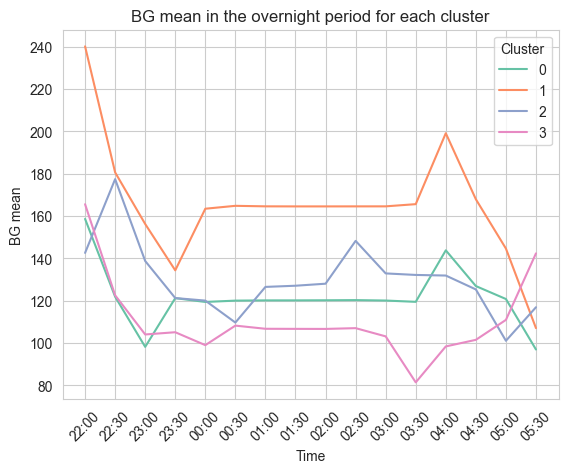

In [6]:
def plot_cluster_bg_profiles(df, col):
    fig, ax = plt.subplots()
    sns.lineplot(df, x='time', y=col, hue='cluster', markers='cluster',  ax=ax, palette='Set2')
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('BG mean')
    plt.legend(title='Cluster')
    plt.title('BG mean in the overnight period for each cluster')
    plt.show()


plot_cluster_bg_profiles(df_long_bg, 'bg mean')

Cluster 0 and cluster 1 show a similar profile but at different elevations of blood glucose. Lets first have a look at DTW similarity for absolute values, and then we can normalise the data to focus on the shape of the profile.

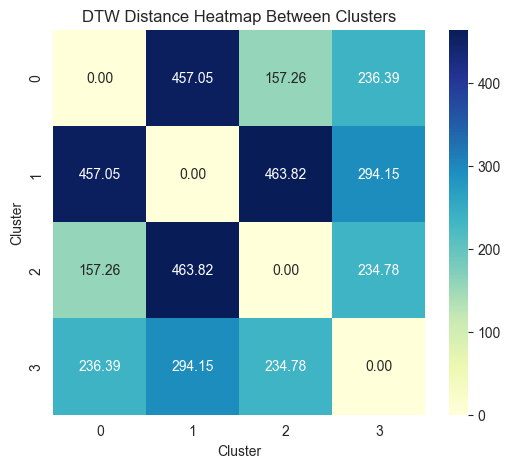

In [7]:
def heatmap_dtw_distance(df, col):
    clusters = sorted(df['cluster'].unique())
    n = len(clusters)
    dtw_matrix = np.zeros((n, n))

    for i, c1 in enumerate(clusters):
        arr1 = df[df['cluster'] == c1][col].to_list()
        for j, c2 in enumerate(clusters):
            if i <= j:
                arr2 = df[df['cluster'] == c2][col].to_list()
                distance, _, _, _ = dtw(arr1, arr2, dist=lambda x, y: abs(x - y))
                dtw_matrix[i, j] = distance
                dtw_matrix[j, i] = distance
    
    dtw_df = pd.DataFrame(dtw_matrix, index=clusters, columns=clusters)
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(dtw_df, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("DTW Distance Heatmap Between Clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Cluster")
    plt.show()

heatmap_dtw_distance(df_long_bg, 'bg mean')

DTW measures the distance between two time series, which is useful for comparing the overnight glucose profiles of different clusters. The heatmap shows the DTW distances between each pair of clusters, with lower values indicating more similar profiles. These results show that clusters 0 and 2 are the most similar, and cluster 3 in general is moderately dissimilar to others. Cluster 1 is the most dissimilar to others on aggregate, with cluster 0 being a mixed result. The most dissimilar clusters are 1 and 2, due to the difference in absolute values and apparent shape. Cluster 1 is the one with the highest overnight glucose levels, and cluster 3 is the one with the lowest overnight glucose levels. Given the distance measure is based on absolute values, and the difference between these, it is not picking up on the level of fluctuation, i.e. the shape. In fact the shape of profiles 0 and 1 are visibly similar. This suggests that there may be a relationship between overnight glucose levels and the shape of the profile. If we normalise the data it will further focus on the shape rather than the absolute values, which may be more useful for comparing clusters, given that clusters may be focusing on people with generally higher or lower overnight glucose levels.

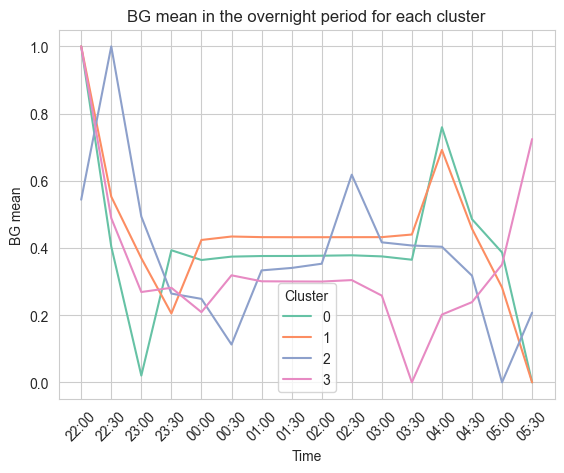

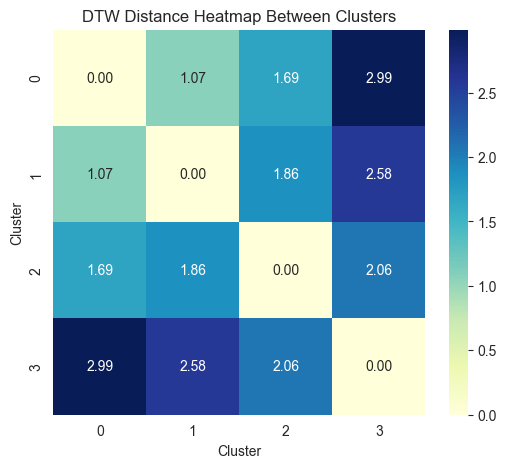

In [8]:
for c, df_c in df_long_bg.groupby('cluster'):
    df_c['bg mean norm'] = (df_c['bg mean'] - df_c['bg mean'].min()) / (df_c['bg mean'].max() - df_c['bg mean'].min())
    df_long_bg.loc[df_long_bg['cluster'] == c, 'bg mean norm'] = df_c['bg mean norm']

plot_cluster_bg_profiles(df_long_bg, 'bg mean norm')

heatmap_dtw_distance(df_long_bg, 'bg mean norm')


These DTW values focus on the shapes of the cluster profiles and provide an alternative perspective on the differences between the clusters. Clusters 3 and 0 have the greatest difference in shape according to the DTW values, which aligns with the observed profiles. Given that we want to understand how relationships between COB and IOB for these groups impact BG, we assume there is a lagged response. Insulin absorption rates can be impacted by a number of different factors including does, insulin mixtures, the site of (and excercise around) the injected area, temperature, and more. Onset of action can range from 5-30 minutes for fast acting insulin, peaking between 15 minutes to 4 hours following the bolus [1]. This means that the impact of COB and IOB on BG can be delayed, and we need to take this into account when analysing the data. We can do this by shifting the COB and IOB values by a certain number of intervals, which will allow us to see how the relationships change over time. The process of shifting the data is known as lagging, and it can be done by using the `shift` method in pandas. We can then compare the relationships between COB, IOB, and BG for different clusters by looking at the correlation coefficients between these variables at different lags. Given our area of interest is the disruption of diurnal patterns that align with the night time period, and we define for the purpose of this study the night time period as between 22:00 and 06:00, we can look at the lagged relationships between COB, IOB ranging up to 4 hours before and therefore revert to our original 17:00-11:00 period for the next analysis.

[1] Donnor T, Sarkar S. Insulin- Pharmacology, Therapeutic Regimens and Principles of Intensive Insulin Therapy. [Updated 2023 Feb 15]. In: Feingold KR, Ahmed SF, Anawalt B, et al., editors. Endotext [Internet]. South Dartmouth (MA): MDText.com, Inc.; 2000-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK278938/

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaled_cols = ['cob_mean_scaled','iob_mean_scaled', 'bg_mean_scaled']
minmax = MinMaxScaler(feature_range=(0, 1))
df_to_compare[scaled_cols] = minmax.fit_transform(df_to_compare[variables])

Now we have scaled columns for the means of COB, IOB and BG, to carry out lagged regression over lagged values of COB and IOB, we can use the `shift` method in pandas to create lagged versions of these columns. We can then use the `statsmodels` library to perform regression analysis on the lagged values of COB and IOB against BG. This will allow us to see how the relationships between these variables change over time, and how they differ between clusters. The following is the code to do this on the overnight period, and we can then look at the results for each cluster.

In [10]:
rel = AnalyseRelationships(df_to_compare.rename(columns={'tsne_cluster_label': 'cluster'}))
ols_results_cob_iob = rel.apply_ols(['cob_lagged', 'iob_lagged'])
ols_results_cob_iob = pd.DataFrame.from_records(ols_results_cob_iob)

The regression parameters for each night show the relationship between COB, IOB and BG for each cluster. The p-values indicate the significance of the relationship, with values below 0.05 indicating a significant relationship. The R-squared value indicates the proportion of variance in BG that is explained by the model, with values closer to 1 indicating a better fit. We can now look at the results for each cluster and see how the relationships differ. Lets see how each of the lags for each cluster compares in terms of the p-values so we can first see which might be the most significant and thus reliable.

In [11]:
def heatmap_regression_values(df, cob_col, iob_col, variable):
    cob_matrix = df.pivot_table(index='cluster', columns='lag', values=cob_col).round(3)
    iob_matrix = df.pivot_table(index='cluster', columns='lag', values=iob_col).round(3)
    
    vmin = min(cob_matrix.min().min(), iob_matrix.min().min())
    vmax = max(cob_matrix.max().max(), iob_matrix.max().max())
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    cmap = "YlGnBu" if variable == 'p-value' else "YlGnBu_r"

    hm0 = sns.heatmap(cob_matrix, annot=True, fmt=".3f", cmap=cmap, ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'COB {variable} by Cluster and Lag')
    hm1 = sns.heatmap(iob_matrix, annot=True, fmt=".3f", cmap=cmap, ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'IOB {variable} by Cluster and Lag')
    
    # Add a single colorbar for both axes
    cbar = fig.colorbar(hm1.collections[0], ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label(variable)
    
    ax[0].set_xlabel('Lag (hours)')
    ax[0].set_ylabel('Cluster')
    ax[1].set_xlabel('Lag (hours)')
    ax[1].set_ylabel('')
    ax[1].set_yticklabels([])
    plt.show()

def heatmap_metrics(df):
    fig, ax = plt.subplots(figsize=(8, 3), ncols=2)
    for i, m in enumerate(['r_squared', 'mse']):
        metric_matrix = df.pivot_table(index='cluster', columns='lag', values=m).round(3)
        if m == 'r_squared':
            vmin, vmax = -1, 1
            ylabel = 'Cluster'
        elif m == 'mse':
            metric_matrix = -metric_matrix  # Invert MSE for heatmap visualisation
            vmin, vmax = -0.05, 0  # Standard range for MSE for comparison
            ylabel = None
        sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap="YlGnBu_r", vmin=vmin, vmax=vmax, ax=ax[i])
        ax[i].set_title(f'{m.upper()} by Cluster and Lag')
        ax[i].set_xlabel('Lag (hours)')
        ax[i].set_ylabel(ylabel)
    plt.show()

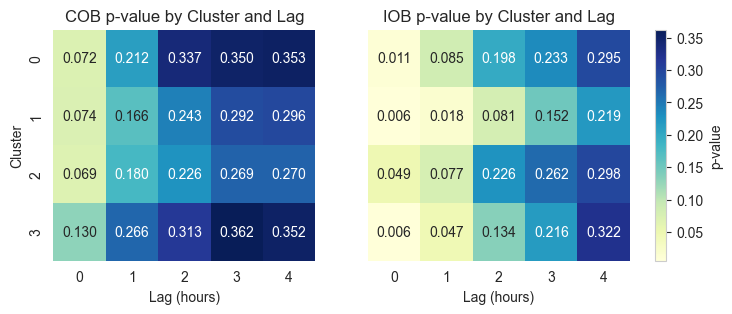

In [12]:
heatmap_regression_values(ols_results_cob_iob, 'pvalue_cob', 'pvalue_iob', 'p-value')

The heatmaps illustrate the mean p-values of all nights at each lag for each cluster. While a lag of 1 indicates the highest significance of relationships for both COB and IOB, for COB, this is outside a confidence interval of 95%, and for IOB, it is under or near the 5% tolerance. This suggests that the linear relationship between IOB and BG is more significant than that of COB and BG. The p-values for COB are generally higher than those for IOB, indicating that the relationship between COB and BG is less significant. We can see that the linear relationship between COB and BG is more loosely coupled that insulin. Let's take a look now at the regression parameters for each cluster and lag, to see how the relationships differ, and the R-squared values to see how well the model fits the data.

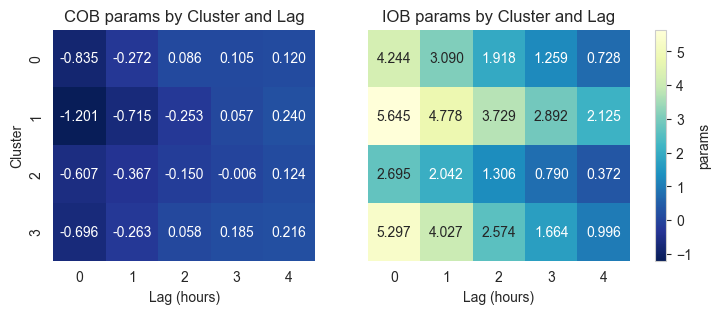

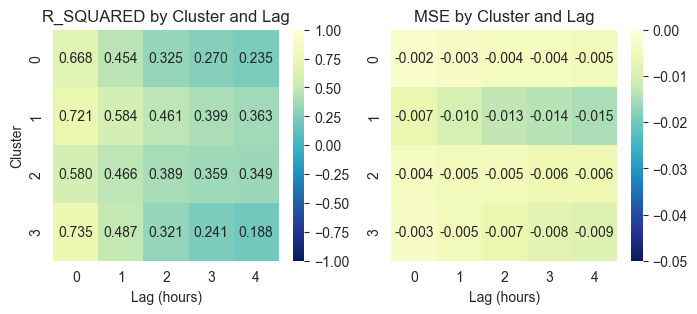

In [13]:
heatmap_regression_values(ols_results_cob_iob, 'params_cob', 'params_iob', 'params')
heatmap_metrics(ols_results_cob_iob)

The relatively high parameters for IOB for lag 1, especially for instance with cluster 1, indicate a strong relationship between IOB and BG at 4.778. Conversely, the negative parameter for the same permutation in COB might be showing the indirect affect that carbohydrate intake is having on BG, but is dominated by the impact of insulin. The R-squared values indicate a moderate fit for the models at lag 1 and a generally declining fit as lags increase, synonymous with the diminishing impact of IOB and COB as time passes. Given that the linear relationship between COB and BG is insignificant, it suggests that the impact of COB on BG may be a more complex relationship that is not captured by simple linear regression. This could be due to the fact that COB is not the only factor influencing BG, and other factors such as IOB, exercise, stress, and sleep may also play a role. The relationship between COB and BG may also be non-linear, which would require a more complex model to capture the relationship accurately. One possible approach to further investigate the relationship between COB and BG is to use a non-linear regression model, such as a polynomial regression or a spline regression. This would allow us to capture the non-linear relationship between COB and BG, and potentially improve the fit of the model. Another approach could be to use a machine learning model, which may capture more complex relationships. To do this, we need to decide on how we might evaluate the model performance. The metrics chosen are R-Squared, Mean Absolute Error (MAE), and Mean Squared Error (MSE). R-Squared is a measure of how well the model fits the data, with values closer to 1 indicating a better fit. MAE is the average absolute difference between the predicted and actual values, with lower values indicating better performance. MSE is the average squared difference between the predicted and actual values, with lower values indicating better performance. We can use these metrics to evaluate the performance of different models and choose the best one for our data. We can then use the metrics to compare each of the clusters which allow us to see how strong the relationships are between COB and BG for each. By using R-Squared scores from our linear regression as a baseline, we can then compare performance of the models against this but the above R-squared values are not helpful given they incorporate COB and IOB together. To establish a baseline, we need the R-squared values only from COB.

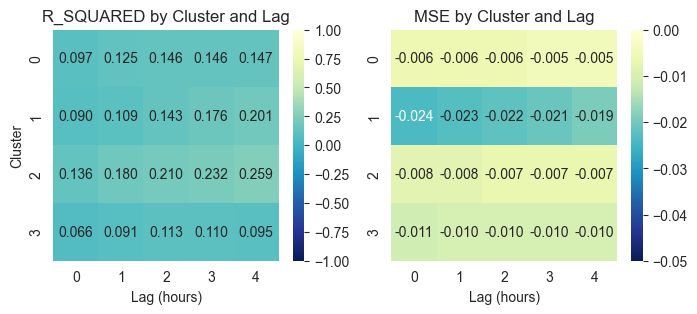

In [14]:
ols_cob_only = rel.apply_ols(['cob_lagged'])
ols_cob_only = pd.DataFrame.from_records(ols_cob_only)
heatmap_metrics(ols_cob_only)

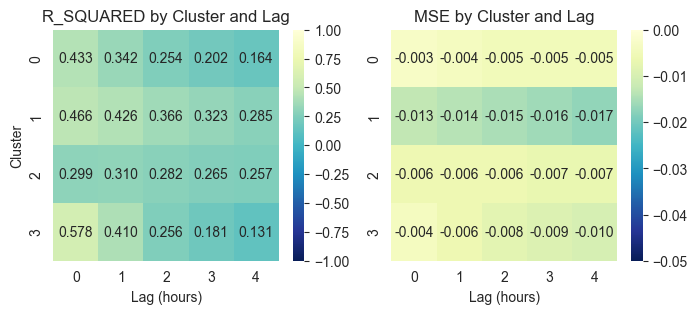

In [15]:
ols_iob_only = rel.apply_ols(['iob_lagged'])
ols_iob_only = pd.DataFrame.from_records(ols_iob_only)
heatmap_metrics(ols_iob_only)

A brief observation here is that the r-squared values appear to generally improve as the lag increases, which is counterintuitive to the expectation that the relationship between COB and BG would weaken over time. This could be due to the fact that the relationship between COB and BG is more nuanced and possibly more lagged. Given the weakness of the relationship here, however, we can keep this in mind to see if other models indicate the same trend and relationship. In the next step we'll experiment with non-linear machine learning models to see if we can capture the relationship between COB and BG more effectively. We will use Support Vector Regression (SVR), Random Forest Regression (RGR) and Decision Tree Regression (DTR) as non-linear regression techniques that can capture complex relationships in the data. We will apply them to the lagged COB values initially and compare the results to the linear regression results. The models will be trained on the lagged COB for the whole night period using cross validation (to minimise the low sample size or max 36 data points per night and the risk of overfitting), and the performance will be evaluated using the same metrics as before: R-Squared and MSE. We canb first look at establishing the baseline using a linear regression model with cross validation as a comparison point.

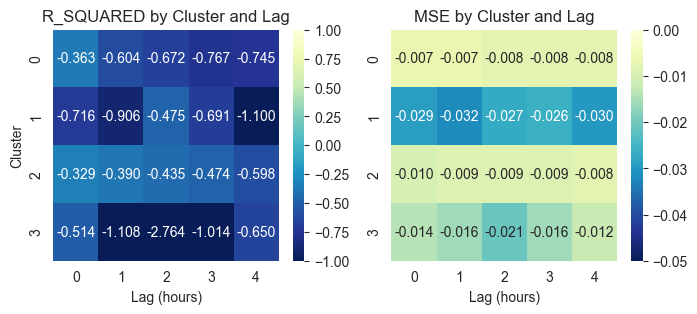

In [16]:
ols_cob_only_cv = rel.apply_cv_regression(model='LinearRegression', variables=['cob_lagged'])
ols_cob_only_cv = pd.DataFrame.from_records(ols_cob_only_cv)
heatmap_metrics(ols_cob_only_cv)

And now check each of the non-linear regression models against this baseline.

In [17]:
# print('Support Vector Regression (SVR) on COB lagged values')
# svm_results = rel.apply_cv_regression(model='SVR', variables=['cob_lagged'])
# svm_results = pd.DataFrame.from_records(svm_results)
# heatmap_metrics(svm_results)

In [18]:
# print('Decision Tree on COB lagged values')
# dt_results = rel.apply_cv_regression(model='DecisionTreeRegressor', variables=['cob_lagged'])
# dt_results = pd.DataFrame.from_records(dt_results)
# heatmap_metrics(dt_results)

In [19]:
# print('Random Forest on COB lagged values')
# rf_results = rel.apply_cv_regression(model='RandomForestRegressor', variables=['cob_lagged'])
# rf_results = pd.DataFrame.from_records(rf_results)
# heatmap_metrics(rf_results)

SVR is the first non-linear regression technique we are applying, and the results notabley poorer results than the linear regression model. The R-squared values are generally lower than those from the linear regression, indicating that the model is not capturing the relationship between COB and BG as well as the linear regression model.

Given the negative R-squared scores across all non-linear models, it is clear that the models are not performing well. This suggests that the relationship between COB and BG is not well captured by these models, and that the relationship may be more complex than can be captured by these non-linear regression techniques. The negative R-squared values indicate that the models are not fitting the data well, and that they are not able to explain the variance in the data. This could be due to a number of factors, including the complexity of the relationship between COB and BG, the presence of noise in the data, or the limitations of the models themselves. Given this, we can conclude that the relationship between COB and BG is not well captured by these non-linear regression techniques, and that further investigation is needed to understand the relationship better. We can also look at how IOB performs in comparison to COB.

In [20]:
# print('Linear Regression on IOB lagged values')
# linear_results = rel.apply_cv_regression(model='LinearRegression',
#                                           variables=['iob_lagged'])
# linear_results = pd.DataFrame.from_records(linear_results)
# heatmap_metrics(linear_results)
#
# print('Support Vector Regression (SVR) on IOB lagged values')
# svm_results = rel.apply_cv_regression(model='SVR', variables=['iob_lagged'])
# svm_results = pd.DataFrame.from_records(svm_results)
# heatmap_metrics(svm_results)
#
# print('Decision Tree on IOB lagged values')
# dt_results = rel.apply_cv_regression(model='DecisionTreeRegressor',
#                                      variables=['iob_lagged'])
# dt_results = pd.DataFrame.from_records(dt_results)
# heatmap_metrics(dt_results)
# print('Random Forest on IOB lagged values')
# rf_results = rel.apply_cv_regression(model='RandomForestRegressor',
#                                      variables=['iob_lagged'])
# rf_results = pd.DataFrame.from_records(rf_results)
# heatmap_metrics(rf_results)

Unsurprisingly, the results for IOB are better than those for COB, aligning to the previous analysis with OLS, with the R-squared values being significantly higher and the MSE values being lower. This suggests that the relationship between IOB and BG is much stronger than that of COB and BG, which aligns with our earlier findings. The non-linear models also perform better on IOB than on COB, with the SVR model performing particularly well. This suggests that the relationship between IOB and BG is more complex than can be captured by a simple linear regression model, but that it can be captured by a non-linear regression model. Overall, these results suggest that the relationship between IOB and BG is much stronger than that of COB and BG, and that non-linear regression models can capture this relationship more effectively than linear regression models. Finally, lets analyse the correlations between the variables in the overnight period for each cluster, to see how they relate to each other. This will allow us to see how the relationships between COB, IOB and BG differ between clusters, and how they change over time. We'll look at Pearson correlation coefficients to study the linear relationships for each cluster and lag, and then Spearman correlation coefficients to study the non-linear relationships for each cluster and lag. This will allow us to see how the relationships between COB, IOB and BG differ between clusters, and how they change over time.

I want to test whether the data is normally distributed, which is a requirement for Pearson correlation. If the data is not normally distributed, we can use Spearman correlation, which does not require normality. We can use the Kolmogorov-Smirnov test to check for normality. The null hypothesis of the Kolmogorov-Smirnov (KS) test (https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm is based on the maximum distance between the empirical distribution function and a normal cumulative distribution function and is appropriate for large sample sizes, in comparison to - for example - the Shapiro-Wilk test. The null hypothesis is that the data is normally distributed, and the alternative hypothesis is that the data is not normally distributed. If the p-value is less than 0.05, we reject the null hypothesis and conclude that the data is not normally distributed. The following will check if the variables are normally distributed for each cluster using the KS test.



In [21]:
def check_normality_cluster(df, col):
    results = []
    for cluster, group in df.groupby('cluster'):
        mean = group[col].mean()
        sigma = group[col].std()
        normalised = (group[col] - mean) / sigma
        p, stat = kstest(normalised, 'norm')
        results.append({'cluster': cluster, 'statistic': stat, 'p-value': p})
    return pd.DataFrame(results)

def check_normality_by_time(df, col, night_start):
    results = []
    for cluster, group in df.reset_index().groupby('cluster'):
        group['time'] = group['datetime'].dt.time
        for time, time_group in group.groupby('time'):
            mean = time_group[col].mean()
            sigma = time_group[col].std()
            normalised = (time_group[col] - mean) / sigma
            p, stat = kstest(normalised, 'norm')
            results.append({'cluster': cluster, 'time': time, 'statistic': stat, 'p-value': p})
    return pd.DataFrame(results)

df_ks_by_cluster = pd.DataFrame(columns=['cluster', 'statistic', 'p-value'])
df_ks_by_cluster = df_ks_by_cluster.astype({'cluster': 'int', 'statistic': 'float', 'p-value': 'float'})
variables = ['bg mean', 'cob mean', 'iob mean']
for v in variables:
    df_ks = check_normality_cluster(df_to_compare.rename(columns={'tsne_cluster_label': 'cluster'}), v)
    df_ks['variable'] = v
    df_ks_by_cluster = pd.concat([df_ks_by_cluster, df_ks])

night_start = time(17, 0)
df_ks_by_time = pd.DataFrame(columns=['cluster', 'time', 'statistic', 'p-value'])
df_ks_by_time = df_ks_by_time.astype({'cluster': 'int', 'time': 'str', 'statistic': 'float', 'p-value': 'float'})
for v in variables:
    df_ks = check_normality_by_time(df_to_compare.rename(columns={'tsne_cluster_label': 'cluster'}), v, night_start)
    df_ks['variable'] = v
    df_ks['minutes_since_night_start'] = df_ks['time'].apply(lambda t: minutes_since_night_start(t, night_start))
    df_ks['rank'] = df_ks['minutes_since_night_start'].rank(method='dense').astype(int)
    df_ks_by_time = pd.concat([df_ks_by_time, df_ks.sort_values(['cluster', 'variable', 'minutes_since_night_start'], ascending=True)])

Cluster p-values for normality using KS test:


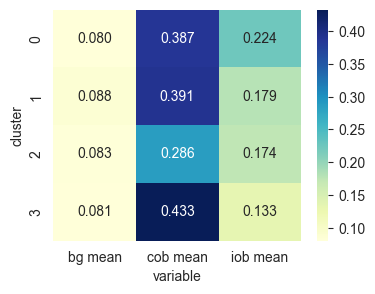

In [22]:
ks_cluster_pval_matrix = df_ks_by_cluster.pivot_table(index='cluster', columns='variable', values='p-value')

print('Cluster p-values for normality using KS test:')
plt.figure(figsize=(4, 3))
sns.heatmap(ks_cluster_pval_matrix, annot=True, fmt=".3f", cmap="YlGnBu")
plt.show()

Cluster p-values for normality using KS test:


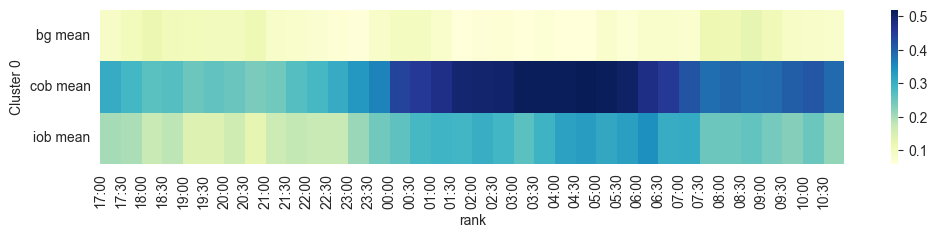

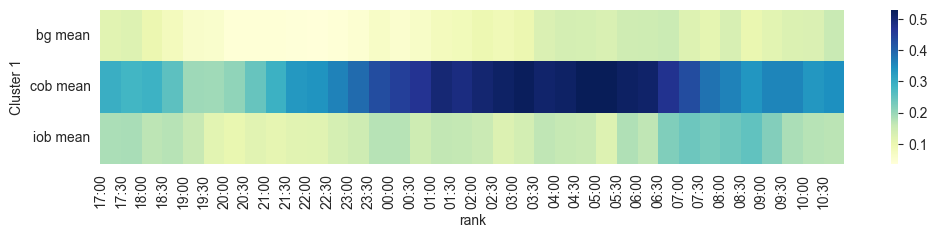

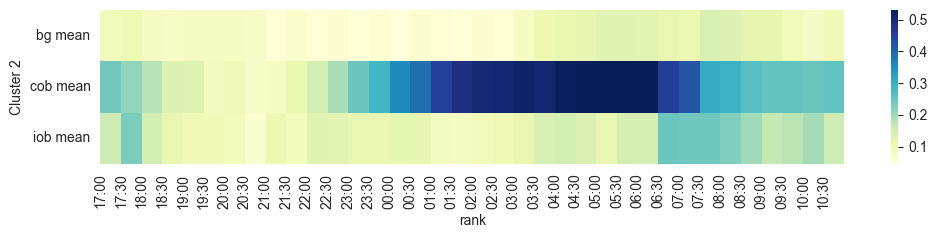

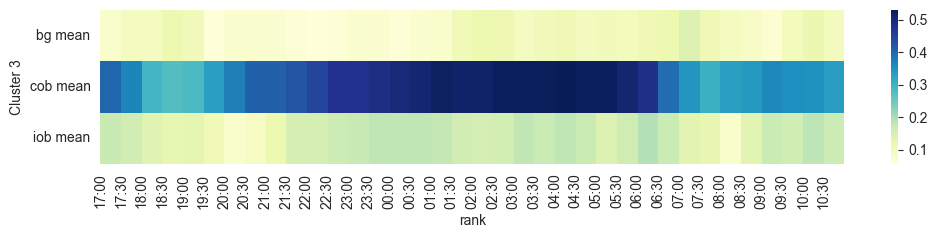

In [30]:
def format_time_to_hhmm(time_obj):
    """Formats a datetime.time object to HH:MM string."""
    return time_obj.strftime('%H:%M')

print('Cluster p-values for normality using KS test:')
x_ticks = df_ks_by_time[['rank','time']].drop_duplicates().sort_values('rank')
x_ticks['time'] = x_ticks['time'].apply(format_time_to_hhmm)
for c, group in df_ks_by_time.groupby('cluster'):
    ks_by_time_pval_matrix = group.pivot_table(index='variable', columns='rank', values='p-value')
    fig = plt.figure(figsize=(12, 2))
    sns.heatmap(ks_by_time_pval_matrix, annot=False, fmt=".3f", cmap="YlGnBu")
    plt.ylabel(f'Cluster {c}')
    plt.xticks(x_ticks['rank']-1, x_ticks['time'], rotation=90)
    plt.show()

In [24]:
df_spearman = rel.calculate_spearman_correlation()
spearman_agg = df_spearman.groupby(['variables', 'lag', 'cluster']).agg({'correlation': 'mean'}).pivot_table(
    index=['variables', 'cluster'], columns=['lag'], values='correlation').round(3).sort_index(axis=1, level=0)

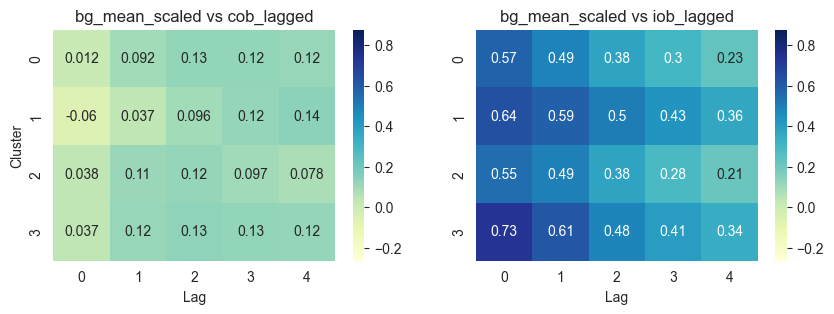

In [25]:
vmin = df_spearman['correlation'].min()
vmax = df_spearman['correlation'].max()
fig, ax = plt.subplots(figsize=(10, 3), ncols=2)
for i, (v, df) in enumerate(spearman_agg.groupby('variables')):
    if v == 'cob_lagged vs iob_lagged':
        continue
    sns.heatmap(df.reset_index(drop=True), annot=True, cmap='YlGnBu', vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(v)
    ax[i].set_ylabel('Cluster' if i==0 else None)
    ax[i].set_xlabel('Lag')
plt.show()


The following looks at how the Spearman correlation changes for each variable against BG over time, for each cluster, but without a lag for COB and IOB.

Spearman correlation for variable bg_mean_scaled vs cob_lagged at lag 0:


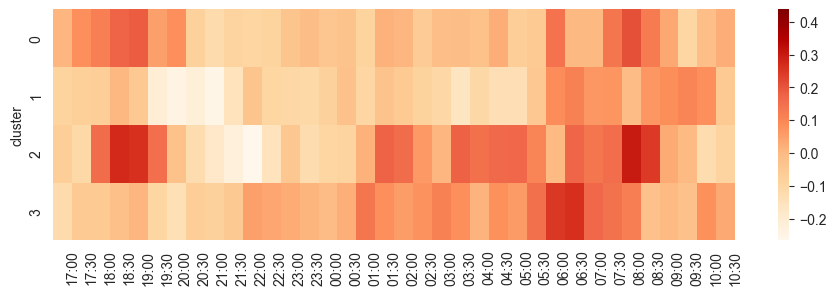

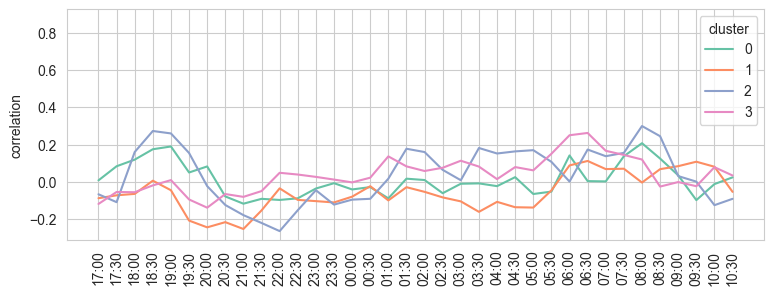

Spearman correlation for variable bg_mean_scaled vs iob_lagged at lag 0:


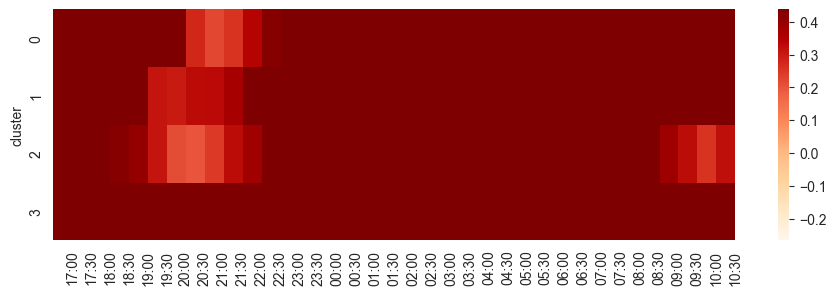

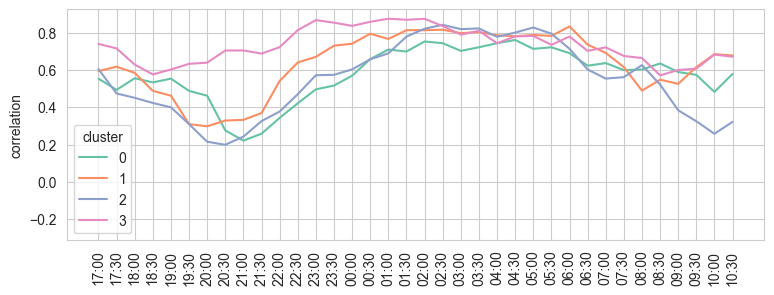

Spearman correlation for variable cob_lagged vs iob_lagged at lag 0:


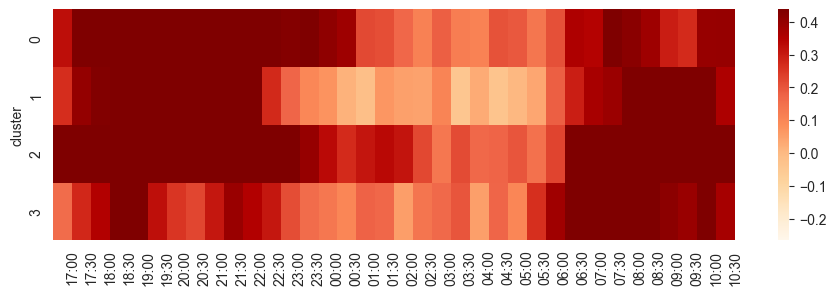

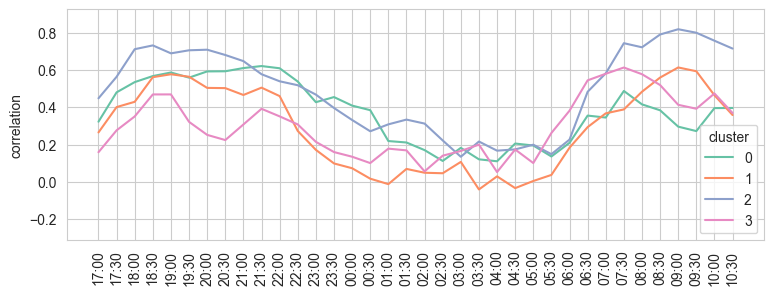

In [37]:
lag = 0
for v, group_df in df_spearman[df_spearman['lag']==lag].groupby('variables'):
    print(f'Spearman correlation for variable {v} at lag {lag}:')
    group_df = group_df.drop(columns='variables')
    group_df['minutes_since_night_start'] = group_df['time'].apply(lambda t: minutes_since_night_start(t, night_start))
    group_df['rank'] = group_df['minutes_since_night_start'].rank(method='dense').astype(int)
    spearman_matrix = group_df.pivot_table(index='cluster', columns='rank', values='correlation', aggfunc='mean')

    fig = plt.figure(figsize=(11, 3))
    sns.heatmap(spearman_matrix, annot=False, fmt=".3f", cmap="OrRd", vmin=vmin, vmax=vmax)
    plt.xticks(x_ticks['rank'], x_ticks['time'], rotation=90)
    plt.xlabel(None)
    plt.show()

    fig = plt.figure(figsize=(9, 3))
    sns.lineplot(group_df, x='rank', y='correlation', hue='cluster', palette='Set2')
    plt.xticks(x_ticks['rank'], x_ticks['time'], rotation=90)
    plt.xlabel(None)
    plt.ylim(df_spearman['correlation'].min()-0.05,df_spearman['correlation'].max()+0.05)
    plt.show()

The are a number of interesting observations we can take from these plots. The first shows us that there is poor correlation between COB and BG across the period for all clusters, generally. Cluster 0 and 2 show a subtle increase in correlation but it is not clear why this would occur specifically with reference to previous analysis. IOB and BG show a consitent pattern of correlation with a dip in correlation after mealtime, presumably as the combined effect that both insulin and carbohydrates are having during the post-prandial period. What is interesting here is the less pronounced affect this has on cluster 3 which is much flatter.

In [38]:
df_long_bg

,cluster,time,bg mean,bg mean norm
0,0,22:00,158.677163,1.000000
1,0,22:30,121.916862,0.404200
2,0,23:00,98.224284,0.020199
3,0,23:30,121.239237,0.393218
4,0,00:00,119.446229,0.364157
...,...,...,...,...
11,3,03:30,81.459674,0.000000
12,3,04:00,98.435983,0.201775
13,3,04:30,101.547591,0.238759
14,3,05:00,110.965649,0.350699


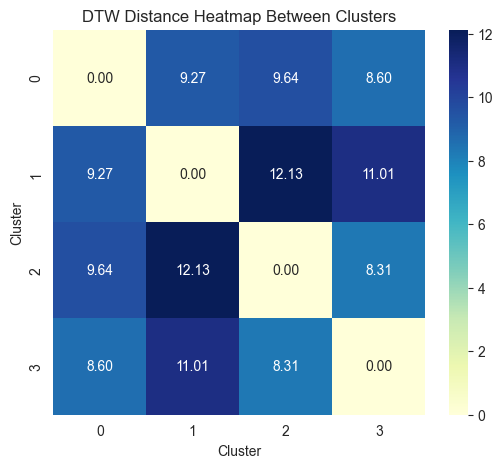

In [41]:
heatmap_dtw_distance(df_spearman[df_spearman['variables']=='bg_mean_scaled vs cob_lagged'], 'correlation')

Spearman correlation for variable bg_mean_scaled vs cob_lagged at lag 0:


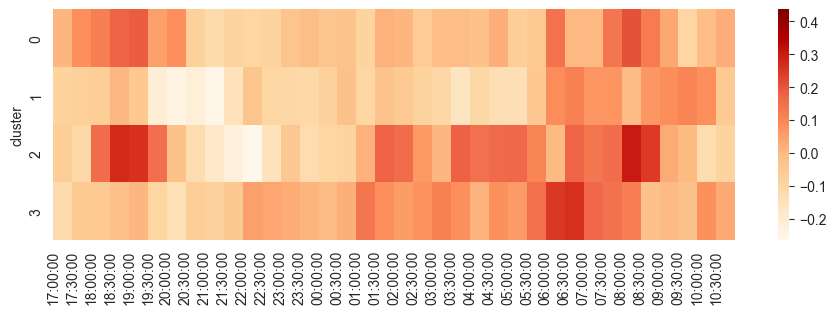

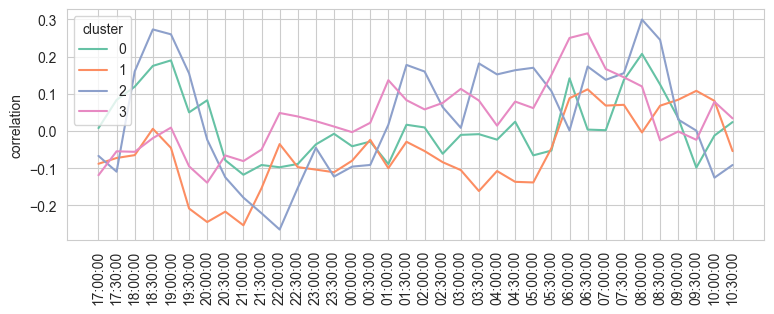

Spearman correlation for variable bg_mean_scaled vs cob_lagged at lag 3:


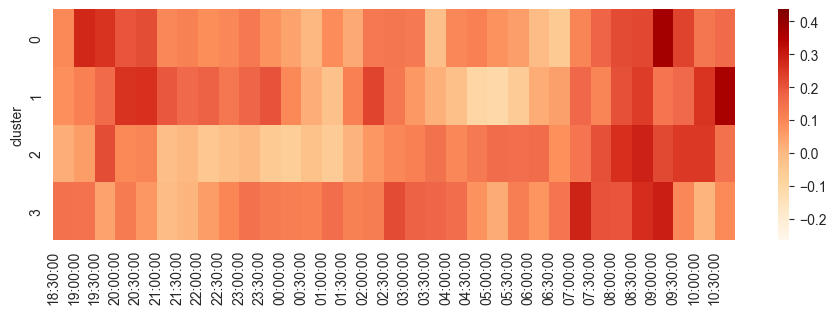

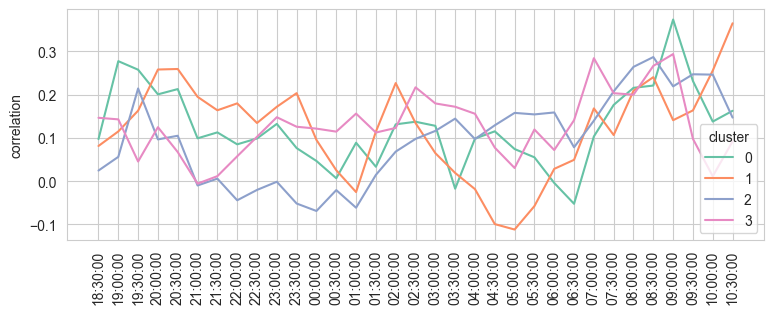

In [27]:
v = 'bg_mean_scaled vs cob_lagged'
sp_new = df_spearman[(df_spearman['variables']==v)].copy()
sp_new = sp_new.drop(columns='variables')
sp_new['minutes_since_night_start'] = sp_new['time'].apply(lambda t: minutes_since_night_start(t, night_start))

vmin = sp_new['correlation'].min()
vmax = sp_new['correlation'].max()

for lag in [0,3]:
    sp_temp = sp_new[sp_new['lag']==lag].copy()
    sp_temp['rank'] = sp_temp['minutes_since_night_start'].rank(method='dense').astype(int)
    print(f'Spearman correlation for variable {v} at lag {lag}:')
    spearman_matrix = sp_temp.pivot_table(index='cluster', columns='rank', values='correlation', aggfunc='mean')
    x_ticks = sp_temp[['rank','time']].reset_index(drop=True).drop_duplicates().sort_values('rank')
    fig = plt.figure(figsize=(11, 3))
    sns.heatmap(spearman_matrix, annot=False, fmt=".3f", cmap="OrRd", vmin=vmin, vmax=vmax)
    plt.xticks(x_ticks['rank']-1, x_ticks['time'], rotation=90)
    plt.xlabel(None)
    plt.show()

    fig = plt.figure(figsize=(9, 3))
    sns.lineplot(sp_temp, x='rank', y='correlation', hue='cluster', palette='Set2')
    plt.xticks(x_ticks['rank'], x_ticks['time'], rotation=90)
    plt.xlabel(None)
    plt.show()